In [1]:
from qick import *
from q3diamond import *

import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from scipy import fft, ifft, fftpack

In [2]:
class Q3DiamondSoc(QickSoc):
    def __init__(self, bitfile=None, force_init_clks=False,ignore_version=True, **kwargs):
        QickSoc.__init__(self, bitfile=bitfile, force_init_clks=force_init_clks, ignore_version=ignore_version, **kwargs)      
            
        # Initialize the configuration (this will calculate the frequency plan)
        #QickConfig.__init__(self, self.cfg)        
        
        # Instantiante IQ constant IPs.
        self.iqs = []
        self.iqs.append(self.axis_constant_iq_0)
        self.iqs.append(self.axis_constant_iq_1)
        self.iqs.append(self.axis_constant_iq_2)
        self.iqs.append(self.axis_constant_iq_3)
        
        # Configure IQ constant IPs.
        for iIQ,iq in enumerate(self.iqs):
            self.iqs[iIQ].config(1, iIQ, self.dacs[self.gens[0].dac]['fs'])
            
        # Instantiate AXIS PFB Readout V2.
        self.readout = self.axis_pfb_readout_v2_0
            
        self.cfg['fs_proc'] = 349.99
        
    def freq2reg(self, fs, f, nbits=32):    
        k_i = np.int64(2**nbits*f/fs)
        return k_i        

In [3]:
# Load bitstream with custom overlay
soc = Q3DiamondSoc(bitfile='./q3diamond.bit',force_init_clks=True)

resetting clocks: 245.76 491.52


In [5]:
#########################
### Always On Outputs ###
#########################
# A complex IQ constant is connected to these DACs.
# The amplitude of the output wave can be controlled by this constant.
# The frequency is controlled with the internal NCO of the DAC.
# NCO's frequency and Nyquist Zone are controlled with the mixer object.
#
# DACs are 0,1,2,3, tile 229.
# Sampling frequency is the same than Tile 230.

# Channel, gain, frequency and nyquist zone.
ch = 0
g = 1
f = 614+23
nq = 1

# IQ block.
iq = soc.iqs[ch]

# Set parameters.
iq.set_iq(i=g,q=g)
soc.mixer.set_freq(f,iq.tile,iq.dac)
soc.mixer.set_nyquist(nq,iq.tile,iq.dac)

print("Setting IQ %d:" %(ch))
print("-> DAC sampling frequency: %f" %(iq.fs))
print("-> DAC output frequency: %f" %(f))
print("-> DAC nyquist zone: %d" %(nq))


Setting IQ 0:
-> DAC sampling frequency: 6881.280000
-> DAC output frequency: 637.000000
-> DAC nyquist zone: 1


In [6]:
######################################
### Signal Generators' Frequencies ###
######################################
for gen in soc.gens:
    name = gen.fullpath
    fs = soc.dacs[gen.dac]['fs']
    
    print("Generator %s sampling frequency: %f" %(gen.fullpath,gen.fs))
    print("Generator %s dac sampling frequency: %f" %(gen.fullpath,soc.dacs[gen.dac]['fs']))
    print("")
    

Generator axis_sg_int4_v1_0 sampling frequency: 1720.320000
Generator axis_sg_int4_v1_0 dac sampling frequency: 6881.280000

Generator axis_sg_int4_v1_1 sampling frequency: 1720.320000
Generator axis_sg_int4_v1_1 dac sampling frequency: 6881.280000

Generator axis_sg_int4_v1_2 sampling frequency: 1720.320000
Generator axis_sg_int4_v1_2 dac sampling frequency: 6881.280000

Generator axis_sg_int4_v1_3 sampling frequency: 1720.320000
Generator axis_sg_int4_v1_3 dac sampling frequency: 6881.280000

Generator axis_signal_gen_v6_4 sampling frequency: 9584.640000
Generator axis_signal_gen_v6_4 dac sampling frequency: 9584.640000

Generator axis_signal_gen_v6_5 sampling frequency: 9584.640000
Generator axis_signal_gen_v6_5 dac sampling frequency: 9584.640000

Generator axis_sg_mux4_v2_6 sampling frequency: 1720.320000
Generator axis_sg_mux4_v2_6 dac sampling frequency: 6881.280000



In [7]:
###################################
### Non-stop tone on DAC 230[0] ###
###################################
# This DAC is connected to one interpolated signal generator.
# The signal is interpolated by 4 inside the DAC, and the NCO is used to mix the signal.

# Frequency and gain.
g = 30000
f = 12

soc.tproc.single_write(addr=100, data=soc.freq2reg(soc.gens[0].fs, f, nbits=soc.gens[0].B_DDS))
soc.tproc.single_write(addr=101, data=(g << 16))


########################
### Start of program ###
########################
prog = QickProgram()

# Register for PMOD0.
prog.regwi(0,1,0x1,"p, $r, imm")

# Registers for SG on channel 0.
prog.memri(1,1,100, "phase, freq")
prog.memri(1,2,101, "gain, addr")
prog.regwi(1,3,(0x5 <<16) + 100,"mode=periodic, outsel=dds, nsamp=100")

# Initial sync.
prog.synci(1000)

# Set Interpolated SG channel 0.
prog.set(0, 1, 1, 2, 3, 0, 0, 0, "ch, p, $ra, $rb, $rc, $rd, $re, $rt")

# Trigger.
prog.seti(7,0,1,0,"ch, p, $r, t")
prog.seti(7,0,0,100,"ch, p, $r, t")

prog.end()

soc.tproc.load_bin_program(prog.compile())

soc.tproc.stop()
soc.tproc.start()

In [8]:
#####################################
### Interpolated SG Mixer Setting ###
#####################################
# Interpolated Signal Generators are channels 0,1,2 and 3 of tProcessor.
# These are connected to DACs 0,1,2,3, on Tile 230.

# Set parameters.
ch = 0
f = 0
nq = 1

# Get Tile and Block for mixer.
tile = soc.dacs[soc.gens[ch].dac]['tile']
dac = soc.dacs[soc.gens[ch].dac]['block']

soc.mixer.set_freq(f,tile,dac)
soc.mixer.set_nyquist(nq,tile,dac)

In [9]:
###################################
### Non-stop tone on DAC 231[0] ###
###################################
# This DAC is connected to a full-speed signal generator.

# Frequency and gain.
g = 30000
f = 1200

soc.tproc.single_write(addr=100, data=soc.freq2reg(soc.gens[4].fs, f, nbits=soc.gens[4].B_DDS))
soc.tproc.single_write(addr=101, data=g)


########################
### Start of program ###
########################
prog = QickProgram()

# Register for PMOD0.
prog.regwi(0,1,0x1,"p, $r, imm")

# Registers for SG on channel 4.
prog.memri(1,1,100, "freq")
prog.memri(1,2,101, "gain")
prog.regwi(1,3,(0x5 <<16) + 100,"mode=periodic, outsel=dds, nsamp=100")

# Initial sync.
prog.synci(1000)

# Set Full-Speed SG channel 4.
prog.set(4, 1, 1, 0, 0, 2, 3, 0, "ch, p, $ra, $rb, $rc, $rd, $re, $rt")

# Trigger.
prog.seti(7,0,1,0,"ch, p, $r, t")
prog.seti(7,0,0,100,"ch, p, $r, t")

prog.end()

soc.tproc.load_bin_program(prog.compile())

soc.tproc.stop()
soc.tproc.start()

In [10]:
###################################
### Full-Speed SG Mixer Setting ###
###################################
# Full-speed Signal Generators are channels 4 and 5 of tProcessor.
# These are connected to DACs 0 and 1 on Tile 231.
# Using the mixer object the nyquist zone can be changed.

# Set parameters.
ch = 4
nq = 1

# Get Tile and Block for mixer.
tile = soc.dacs[soc.gens[ch].dac]['tile']
dac = soc.dacs[soc.gens[ch].dac]['block']

soc.mixer.set_nyquist(nq,tile,dac)

In [11]:
############################################
### Configuration of AXIS PFB Readout V2 ###
############################################
adc = soc.adcs['20']

# Configure sampling frequency: ADC applies x2 decimation. PFB applies x4 decimation.
soc.readout.configure(fs=adc['fs']/2)

# Configure all channels to bypass DDS product.
soc.readout.set_out("dds")

# Set DDS frequency.
soc.readout.set_freq(ch=0, f=23)

# Route outputs.
soc.readout.set_chsel(ch=0, out=0)
soc.readout.set_chsel(ch=1, out=1)
soc.readout.set_chsel(ch=2, out=2)
soc.readout.set_chsel(ch=3, out=3)

# Channel center and channel bandwidth.
CC = (adc['fs']/2)/soc.readout.NCH
CB = 2*CC

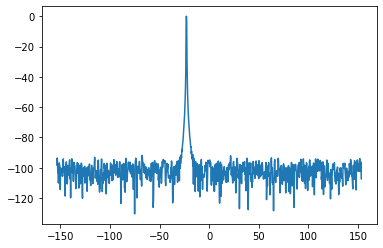

In [12]:
##################################
### Data capture on AVG BUFFER ###
##################################
# Number of points.
N = 1000

# Channel and sampling frequency.
ch = 0
avg_buf = soc.avg_bufs[ch]
fs = soc.adcs['20']['fs']
fs_dec = fs/8

# Configure avg_buf.
avg_buf.config(length=N)

# Enable capture on avg_buf.
avg_buf.enable_buf()

########################
### Start of program ###
########################
# Simple QickProgram to set avg_buf trigger.
prog = QickProgram()

# Register for PMOD0 and avg_buf trigger bit.
prog.regwi(0,1,(1 << 0) + (1 << avg_buf.trigger_bit),"p, $r, imm")

# Initial sync.
prog.synci(1000)

# Trigger.
prog.seti(7,0,1,0,"ch, p, $r, t")
prog.seti(7,0,0,100,"ch, p, $r, t")

prog.end()

soc.tproc.load_bin_program(prog.compile())

soc.tproc.stop()
soc.tproc.start()

#####################
### Transfer data ###
#####################
i,q = avg_buf.transfer_buf(length=N)

#####################
### Plot spectrum ###
#####################
x = i + 1j*q
w = sp.hanning(len(x))
xw = x*w
Y = sp.fftpack.fftshift(sp.fft(xw))
F = (np.arange(len(Y))/len(Y)-0.5)*fs_dec
plt.plot(F,20*np.log10(abs(Y)/np.max(abs(Y))))

In [17]:
soc.gens

In [13]:
####################
### SG Mux4 Test ###
####################
# Muxed Signal Generator is connected to channel 6 of tProcessor.
# This generator is connected to DAC 0 on Tile 228.
# Using the mixer object the nyquist zone can be changed.
gen = soc.gens[6]
gen.set_freq(f=10, out=0)
gen.set_freq(f=133, out=1)
gen.set_freq(f=310, out=2)
gen.set_freq(f=450, out=3)
gen.set_gain(g=30000, out=0)
gen.set_gain(g=20000, out=1)
gen.set_gain(g=10000, out=2)
gen.set_gain(g=5000, out=3)

# Signal duration (uSeconds)
T = 8000000
N = T*gen.fs/gen.NDDS
soc.tproc.single_write(addr=100, data=N)
print("N = %d" %N)

########################
### Start of program ###
########################
prog = QickProgram()

# Register for PMOD0 and avg_buf trigger bit.
prog.regwi(0,1,(1 << 0) + (1 << avg_buf.trigger_bit),"p, $r, imm")

# Registers for SG on channel 6.
prog.memri(1,1,100, "nsamp")
prog.regwi(1,2,0xf,"mask")

# Initial sync.
prog.synci(1000)

# Set SG channel 6.
prog.set(gen.tproc_ch, 1, 1, 2, 0, 0, 0, 0, "ch, p, $ra, $rb, $rc, $rd, $re, $rt")
prog.set(gen.tproc_ch, 1, 1, 2, 0, 0, 0, 0, "ch, p, $ra, $rb, $rc, $rd, $re, $rt")

# Trigger.
prog.seti(7,0,1,0,"ch, p, $r, t")
prog.seti(7,0,0,100,"ch, p, $r, t")

prog.end()

soc.tproc.load_bin_program(prog.compile())

soc.tproc.stop()
soc.tproc.start()

N = 3440640000


In [277]:
#############################
### Mux4 SG Mixer Setting ###
#############################
# Mux4 Signal Generator is connected to channel 6 of tProcessor.
# This block is driving DAC 0 of Tile 228.

# Set parameters.
ch = 6
f = 614
nq = 1

# Get Tile and Block for mixer.
tile = soc.dacs[soc.gens[ch].dac]['tile']
dac = soc.dacs[soc.gens[ch].dac]['block']

soc.mixer.set_freq(f,tile,dac)
soc.mixer.set_nyquist(nq,tile,dac)

N = 3440640000


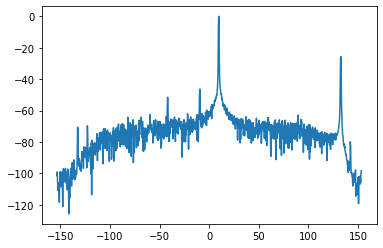

In [279]:
############################
### Mux4 <-> PFB Readout ###
############################
# PFB Readout block is connected to ADC0 on Tile 226.

############################################
### Configuration of AXIS PFB Readout V2 ###
############################################
adc = soc.adcs['20']

# Configure sampling frequency: ADC applies x2 decimation. PFB applies x4 decimation.
soc.readout.configure(fs=adc['fs']/2)

# Configure all channels' output.
soc.readout.set_out("input")

# Set DDS frequency.
soc.readout.set_freq(ch=0, f=23)

# Route outputs.
soc.readout.set_chsel(ch=0, out=0)
soc.readout.set_chsel(ch=1, out=1)
soc.readout.set_chsel(ch=2, out=2)
soc.readout.set_chsel(ch=3, out=3)

# Channel center and channel bandwidth.
CC = (adc['fs']/2)/soc.readout.NCH
CB = 2*CC

#############################
### Mux4 SG Mixer Setting ###
#############################
# Mux4 Signal Generator is connected to channel 6 of tProcessor.
# This block is driving DAC 0 of Tile 228.

# Set parameters.
ch = 6
f = 614
nq = 1

# Get Tile and Block for mixer.
tile = soc.dacs[soc.gens[ch].dac]['tile']
dac = soc.dacs[soc.gens[ch].dac]['block']

soc.mixer.set_freq(f,tile,dac)
soc.mixer.set_nyquist(nq,tile,dac)

####################
### SG Mux4 Test ###
####################
gen = soc.gens[6]
gen.set_freq(f=10, out=0)
gen.set_freq(f=133, out=1)
gen.set_freq(f=310, out=2)
gen.set_freq(f=450, out=3)

# Signal duration (uSeconds)
T = 8000000
N = T*gen.fs/gen.NDDS
soc.tproc.single_write(addr=100, data=N)
print("N = %d" %N)

##################################
### Data capture on AVG BUFFER ###
##################################
# Number of points.
N = 1000

# Channel and sampling frequency.
for ch in range(4):
    avg_buf = soc.avg_bufs[ch]
    fs = soc.adcs['20']['fs']
    fs_dec = fs/8

    # Configure avg_buf.
    avg_buf.config(length=N)

    # Enable capture on avg_buf.
    avg_buf.enable_buf()

########################
### Start of program ###
########################
prog = QickProgram()

# Register for PMOD0.
prog.regwi(0,1,(1 << 0) + (0xf0),"p, $r, imm")

# Registers for SG on channel 6.
prog.memri(1,1,100, "nsamp")
prog.regwi(1,2,0xf,"mask")

# Initial sync.
prog.synci(1000)

# Set SG channel 6.
prog.set(gen.tproc_ch, 1, 1, 2, 0, 0, 0, 0, "ch, p, $ra, $rb, $rc, $rd, $re, $rt")
#prog.set(gen.tproc_ch, 1, 1, 2, 0, 0, 0, 0, "ch, p, $ra, $rb, $rc, $rd, $re, $rt")

# Trigger.
prog.seti(7,0,1,0,"ch, p, $r, t")
prog.seti(7,0,0,100,"ch, p, $r, t")

prog.end()

soc.tproc.load_bin_program(prog.compile())

soc.tproc.stop()
soc.tproc.start()

#####################
### Transfer data ###
#####################
ch = 0
avg_buf = soc.avg_bufs[ch]
i,q = avg_buf.transfer_buf(length=N)

#####################
### Plot spectrum ###
#####################
x = i + 1j*q
w = sp.hanning(len(x))
xw = x*w
Y = sp.fftpack.fftshift(sp.fft(xw))
F = (np.arange(len(Y))/len(Y)-0.5)*fs_dec
plt.plot(F,20*np.log10(abs(Y)/np.max(abs(Y))))

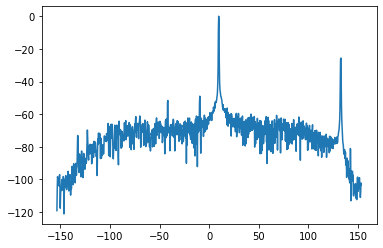

In [26]:
#####################
### Transfer data ###
#####################
ch = 0
avg_buf = soc.avg_bufs[ch]
i,q = avg_buf.transfer_buf(length=N)

#####################
### Plot spectrum ###
#####################
x = i + 1j*q
w = sp.hanning(len(x))
xw = x*w
Y = sp.fftpack.fftshift(sp.fft(xw))
F = (np.arange(len(Y))/len(Y)-0.5)*fs_dec
plt.plot(F,20*np.log10(abs(Y)/np.max(abs(Y))))

In [67]:
#################################################
### Last value/phase reset test on DAC 231[0] ###
#################################################
# This DAC is connected to a full-speed signal generator.

# Frequency and gain.
g = 30000
f = 200

soc.tproc.single_write(addr=100, data=soc.freq2reg(soc.gens[5].fs, f, nbits=soc.gens[5].B_DDS))
soc.tproc.single_write(addr=101, data=g)

########################
### Start of program ###
########################
prog = QickProgram()

# Register for PMOD0.
prog.regwi(0,1,0x1,"p, $r, imm")

# Registers for SG on channel 4.
prog.memri(1,1,100, "freq")
prog.memri(1,2,101, "gain")
prog.regwi(1,3,(0x11 <<16) + 100,"phrst=0, stdy=0, mode=nsamp, outsel=dds, nsamp=100")

# Initial sync.
prog.synci(1000)

# Set Full-Speed SG channel 4.
prog.set(4, 1, 1, 0, 0, 2, 3, 0, "ch, p, $ra, $rb, $rc, $rd, $re, $rt")

# Trigger.
prog.seti(7,0,1,0,"ch, p, $r, t")
prog.seti(7,0,0,100,"ch, p, $r, t")

prog.end()

soc.tproc.load_bin_program(prog.compile())

soc.tproc.stop()
soc.tproc.start()

In [274]:
#######################################################
### Last Value/Phase Reset on DAC 230[0] and 230[2] ###
#######################################################
# This DACs are connected to interpolated signal generators.

#####################################
### Interpolated SG Mixer Setting ###
#####################################
# Interpolated Signal Generators are channels 0,1,2 and 3 of tProcessor.
# These are connected to DACs 0,1,2,3, on Tile 230.

# Set parameters.
f = 100
nq = 1

# Get Tile and Block for mixer.
ch = 0
tile = soc.dacs[soc.gens[ch].dac]['tile']
dac = soc.dacs[soc.gens[ch].dac]['block']
soc.mixer.set_freq(f,tile,dac)

# Get Tile and Block for mixer.
ch = 2
tile = soc.dacs[soc.gens[ch].dac]['tile']
dac = soc.dacs[soc.gens[ch].dac]['block']
soc.mixer.set_freq(f,tile,dac)

# Frequency and gain.
g = 30000
f = 12
fi = 200

freg = soc.freq2reg(soc.gens[0].fs, f, nbits=soc.gens[0].B_DDS)
fireg = soc.freq2reg(soc.gens[0].fs, fi*soc.gens[0].fs/360, nbits=soc.gens[0].B_DDS)

soc.tproc.single_write(addr=100, data=freg)
soc.tproc.single_write(addr=101, data=(fireg << 16) + freg)
soc.tproc.single_write(addr=102, data=(g << 16))

########################
### Start of program ###
########################
prog = QickProgram()

# Register for PMOD0.
prog.regwi(0,1,0x1,"p, $r, imm")

# Registers.
prog.memri(1,1,100, "phase, freq")
prog.memri(1,2,101, "phase, freq")
prog.memri(1,3,102, "gain, addr")
prog.regwi(1,4,(0x19 << 16) + 200,"phrst=1,stdysel=1,mode=nsamp, outsel=dds, nsamp=100")

# Initial sync.
prog.synci(1000)

# Set Interpolated SG channel 0 and 2.
prog.set(0, 1, 1, 3, 4, 0, 0, 0, "ch, p, $ra, $rb, $rc, $rd, $re, $rt")
prog.set(2, 1, 2, 3, 4, 0, 0, 0, "ch, p, $ra, $rb, $rc, $rd, $re, $rt")

# Trigger.
prog.seti(7,0,1,0,"ch, p, $r, t")
prog.seti(7,0,0,100,"ch, p, $r, t")

prog.end()

soc.tproc.load_bin_program(prog.compile())

soc.tproc.stop()
soc.tproc.start()

In [10]:
#######################################################
### Last Value/Phase Reset on DAC 231[0] and 231[1] ###
#######################################################
# This DAC is connected to a full-speed signal generator.

# Frequency and gain.
g = 30000
f = 200
fi = 200

freg = soc.freq2reg(soc.gens[4].fs, f, nbits=soc.gens[4].B_DDS)
fireg = soc.freq2reg(soc.gens[4].fs, fi*soc.gens[4].fs/360, nbits=soc.gens[4].B_DDS)

soc.tproc.single_write(addr=100, data=freg)
soc.tproc.single_write(addr=101, data=fireg)
soc.tproc.single_write(addr=102, data=g)

########################
### Start of program ###
########################
prog = QickProgram()

# Register for PMOD0.
prog.regwi(0,1,0x1,"p, $r, imm")

# Registers.
prog.memri(1,1,100, "freq")
prog.memri(1,2,101, "phase")
prog.memri(1,3,102, "gain")
prog.regwi(1,4,(0x11 << 16) + 200,"phrst=1,stdysel=1,mode=nsamp, outsel=dds, nsamp=200")

# Initial sync.
prog.synci(1000)

# Set Interpolated SG channel 0 and 2.
prog.set(4, 1, 1, 0, 0, 3, 4, 0, "ch, p, $ra, $rb, $rc, $rd, $re, $rt")
prog.set(5, 1, 1, 2, 0, 3, 4, 0, "ch, p, $ra, $rb, $rc, $rd, $re, $rt")

# Trigger.
prog.seti(7,0,1,0,"ch, p, $r, t")
prog.seti(7,0,0,100,"ch, p, $r, t")

prog.end()

soc.tproc.load_bin_program(prog.compile())

soc.tproc.stop()
soc.tproc.start()